In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from pyHalo.PresetModels.cdm import CDM
from pyHalo.realization_extensions import RealizationExtensions
from lenstronomy.LensModel.lens_model import LensModel

## Adding a population of globular clusters to a population of CDM halos

In [2]:
zlens, zsource = 0.5, 2.0
cone_opening_angle_arcsec = 6.0
realizationCDM = CDM(zlens, zsource, LOS_normalization=1.0, sigma_sub=0.1, 
                     cone_opening_angle_arcsec=cone_opening_angle_arcsec,
                    log_mlow=7.0)
kwargs_mass_sheet={'log_mlow_sheets': 7.0, 'kappa_scale_subhalos': 0.1}
lens_model_list_halos, lens_redshift_array_halos, kwargs_halos, _ = realizationCDM.lensing_quantities(kwargs_mass_sheet=kwargs_mass_sheet)
print('number of halos: ', len(realizationCDM.halos))

number of halos:  1769


The GC mass funciton is assumed to be log-normal and the GCs have density profiles given by 

\begin{equation}
\rho\left(r,r_c,\gamma\right) = \rho_0 \left(1+r^2/r_c^2\right)^{\gamma/2}
\end{equation}

The free parameters are 
- log10_mgc_mean: the mean value of log10(m), where m is the mass of the GC inside a radius $R_{\rm{gc}}$ 
- log10_mgc_sigma: the variance of the log-normal mass function 
- gamma_mean: the average value of $\gamma$ for the population
- gamma_sigma: the scatter in $\gamma$, the distribution is assumed to be uniform, centered on gamma_mean $\pm$ gamma_sigma
- gc_concentration_mean: the mean value of $R_{\rm{gc}} / r_c$ for the population 
- gc_concentration_sigma: same as gamma_sigma, but for gc_concentration
- gc_size_mean: the size $R_{\rm{gc}}$ of a $10^5 M_{\odot}$ gc; R is assumed to scale with mass
\begin{equation}
R_{\rm{gc}} = R \left(m/10^5\right)^{1/3}
\end{equation}
- gc_size_sigma: same as the other sigma parameters, but pertaining to $R$ 

Given the total mass $m$ and $r_c = R_{\rm{gc}} / c$, we can solve for $\rho_0$

In [4]:
ext = RealizationExtensions(realizationCDM)
log10_mgc_mean = 5.0
log10_mgc_sigma = 0.5
rendering_radius_arcsec = 0.25
center_x = [1.0, 0.0, -1.0, 0.0]
center_y = [0.0, 1.0, 0.0, -1.0]

realizationCDM_with_GCs = ext.add_globular_clusters(log10_mgc_mean,
                                         log10_mgc_sigma,
                                         rendering_radius_arcsec,
                                                   center_x=center_x, center_y=center_y)
print('number of GCs: ', len(realizationCDM_with_GCs.halos) - len(realizationCDM.halos))
lens_model_list_gcs, lens_redshift_array_gcs, kwargs_halos_gcs, _ = realizationCDM_with_GCs.lensing_quantities(
    kwargs_mass_sheet=kwargs_mass_sheet
)

number of GCs:  15


In [5]:
kwargs_macromodel = [{'theta_E': 1., 'center_x': 0., 'center_y': 0., 'e1': 0.2, 'e2': -0.1, 'gamma': 2.},
                    {'gamma1': -0.04, 'gamma2': 0.09}]
lens_model_list_macro = ['EPL', 'SHEAR']
lens_model_macro = LensModel(lens_model_list_macro)

lens_model = LensModel(lens_model_list_macro + lens_model_list_halos, lens_redshift_list=[0.5]*2 + list(lens_redshift_array_halos),
                      z_source=2.0, multi_plane=True)
lens_model_gcs = LensModel(lens_model_list_macro + lens_model_list_gcs, lens_redshift_list=[0.5]*2 + list(lens_redshift_array_gcs),
                      z_source=2.0, multi_plane=True)
kwargs = kwargs_macromodel + kwargs_halos
kwargs_gcs = kwargs_macromodel + kwargs_halos_gcs 


In [6]:
npix = 100 
_x = _y = np.linspace(-1.6, 1.6, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape
kappa = lens_model.kappa(xx.ravel(), yy.ravel(), kwargs).reshape(shape0)
kappa_gcs = lens_model_gcs.kappa(xx.ravel(), yy.ravel(), kwargs_gcs).reshape(shape0)
kappa_macro = lens_model_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macromodel).reshape(shape0)

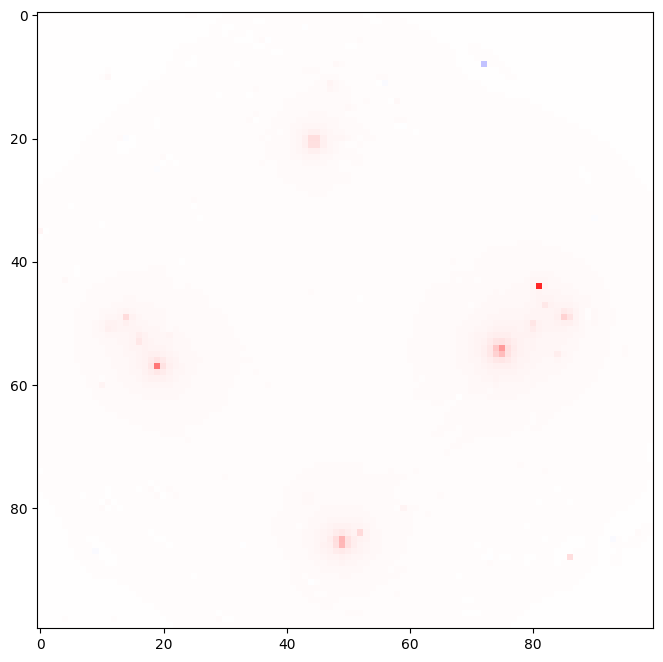

In [7]:
fig = plt.figure(1)
fig.set_size_inches(8,8)

vmin_max = 0.05
cmap = 'bwr'
#plt.scatter(realizationCDM_with_GCs.x, realizationCDM_with_GCs.y)
plt.imshow(kappa_gcs - kappa, vmin=-vmin_max, vmax=vmin_max, cmap=cmap)

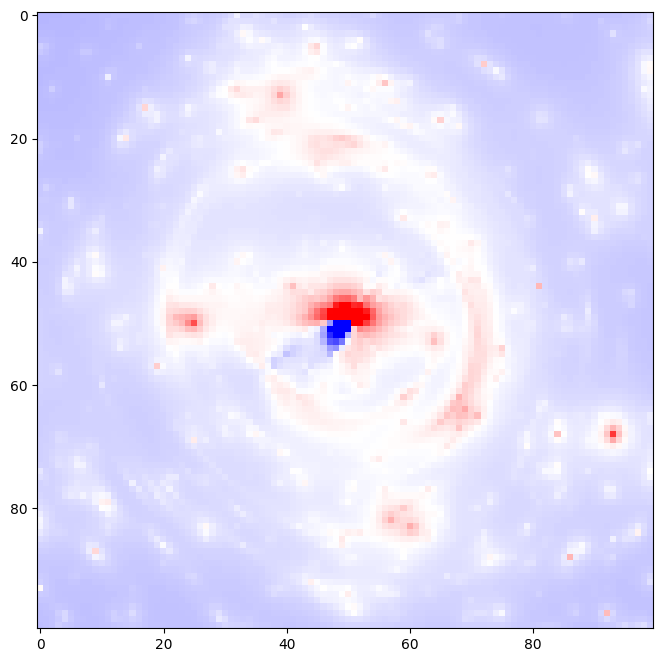

In [8]:
fig = plt.figure(1)
fig.set_size_inches(8,8)

vmin_max = 0.1
cmap = 'bwr'
plt.imshow(kappa_gcs-kappa_macro, vmin=-vmin_max, vmax=vmin_max, cmap=cmap)

In [9]:
real = CDM(zlens, zsource, LOS_normalization=0.0, sigma_sub=0.0, 
                     cone_opening_angle_arcsec=cone_opening_angle_arcsec,
                    log_mlow=7.0)
ext = RealizationExtensions(real)
log10_mgc_mean = 4.7
log10_mgc_sigma = 0.01
realization_GCs = ext.add_globular_clusters(log10_mgc_mean,
                                         log10_mgc_sigma,
                                         rendering_radius_arcsec, 
                                            gc_size_mean=100,
                                            gc_size_sigma=0.1,
                                            gc_concentration_mean=80,
                                            gc_concentration_sigma=0.1,
                                            gc_surface_mass_density=1e7,
                                        center_x=center_x, center_y=center_y)
central_density = []
size = []
masses = []
for gc in realization_GCs.halos:
    rho0, gc_size_kpc, gamma, r_core_kpc = gc.profile_args
    central_density.append(rho0)
    size.append(gc_size_kpc)
    masses.append(gc.mass)

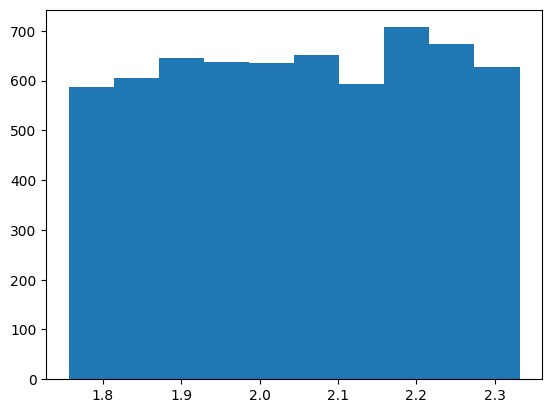

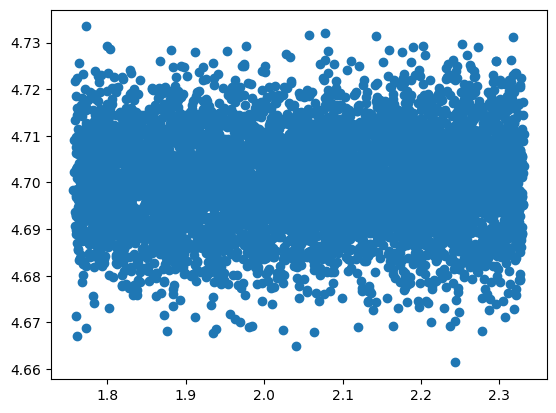

In [10]:
kpc_per_lyr = 0.31 * 1e-3
rho0_msun_per_cubiclyr = np.array(central_density) * kpc_per_lyr ** 3
plt.hist(np.log10(rho0_msun_per_cubiclyr)); plt.show()

plt.scatter(np.log10(rho0_msun_per_cubiclyr), np.log10(masses))

In [11]:
### Estimate the surface mass density

In [12]:
rhos, rs, r200 = real.lens_cosmo.NFW_params_physical(10**13., 5, 0.5)
R_ein = 8.0 # kpc
R_eff = 2 * R_ein
R = 8 * R_eff
x = R/rs
fx = np.log(1+x) -x/(1+x)
nfw_mass = 4 * np.pi * rs ** 3 * rhos * fx
f = 3.4e-5
M_globular = f * nfw_mass
print(np.log10(M_globular))
area = np.pi * (3 * R_ein) ** 2
print('surface mass density: ', np.log10(M_globular/area))

8.107389702628918
surface mass density:  4.849817346511573
